In [1]:
# this is the new scripts for the challenge book //Jung Kweon Woo
# some competition notebook codes explanations
# 1. check if a competition has data leakage (in notebooks/discussions)
# 2. top kaggler that submit below 200
# spec: tabular data, standard ML pipline
# RAM 32GB, CPU 8core
# if the data is larger than mem, then use online learning (Vowpal Wabbit)
# spec: image/audio, DL, GPU RAM 8GB (GTX10180)

# Kaggler like using tree-based model, (for tabular data) Gradient Boosting Decision Trees -> XGBoost, LightGBM, CatBoost
# also, bagging-based RandomForest, ExtraTrees -> scilearn
# (for DL models), PyTorch, TensorFlow, Keras
# Sometimes, linear model has similar performance with tree-based model, if cannot loaded in RAM, then use Vowpal Wabbit
# for hyperparameter optimizations, use hyperopt, scikit-optimize, spearmint
# Baseline models means the basic ML pipline: to check if ML pipline correctly work
# To fix the reproductivity, need to fix random_seed

In [29]:
# 1. Santander Product Recommendation // tabular data
# MAP@7
import pandas as pd
import numpy as np

trn = pd.read_csv("../santander/train_ver2.csv.zip")
trn.shape

/Users/shenghu/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5,8,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  self.showsyntaxerror()


(13647309, 48)

In [3]:
trn.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [9]:
for col in trn.columns:
    # print("%s \n" % trn[col].head())
    print(f"{trn[col].head()} \n" )

0    2015-01-28
1    2015-01-28
2    2015-01-28
3    2015-01-28
4    2015-01-28
Name: fecha_dato, dtype: object 

0    1375586
1    1050611
2    1050612
3    1050613
4    1050614
Name: ncodpers, dtype: int64 

0    N
1    N
2    N
3    N
4    N
Name: ind_empleado, dtype: object 

0    ES
1    ES
2    ES
3    ES
4    ES
Name: pais_residencia, dtype: object 

0    H
1    V
2    V
3    H
4    V
Name: sexo, dtype: object 

0     35
1     23
2     23
3     22
4     23
Name: age, dtype: object 

0    2015-01-12
1    2012-08-10
2    2012-08-10
3    2012-08-10
4    2012-08-10
Name: fecha_alta, dtype: object 

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: ind_nuevo, dtype: float64 

0          6
1         35
2         35
3         35
4         35
Name: antiguedad, dtype: object 

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: indrel, dtype: float64 

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: ult_fec_cli_1t, dtype: object 

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: ind

In [10]:
trn.info() # need to change all the datatypes to int/float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 48 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   fecha_dato             object 
 1   ncodpers               int64  
 2   ind_empleado           object 
 3   pais_residencia        object 
 4   sexo                   object 
 5   age                    object 
 6   fecha_alta             object 
 7   ind_nuevo              float64
 8   antiguedad             object 
 9   indrel                 float64
 10  ult_fec_cli_1t         object 
 11  indrel_1mes            object 
 12  tiprel_1mes            object 
 13  indresi                object 
 14  indext                 object 
 15  conyuemp               object 
 16  canal_entrada          object 
 17  indfall                object 
 18  tipodom                float64
 19  cod_prov               float64
 20  nomprov                object 
 21  ind_actividad_cliente  float64
 22  renta           

In [12]:
num_cols = [col for col in trn.columns[:24] if trn[col].dtype in ['int64', 'float64']]
trn[num_cols].describe() # descriptive statistics

,ncodpers,ind_nuevo,indrel,tipodom,cod_prov,ind_actividad_cliente,renta
count,1.364731e+07,1.361958e+07,1.361958e+07,13619574.0,1.355372e+07,1.361958e+07,1.085293e+07
mean,8.349042e+05,5.956184e-02,1.178399e+00,1.0,2.657147e+01,4.578105e-01,1.342543e+05
std,4.315650e+05,2.366733e-01,4.177469e+00,0.0,1.278402e+01,4.982169e-01,2.306202e+05
min,1.588900e+04,0.000000e+00,1.000000e+00,1.0,1.000000e+00,0.000000e+00,1.202730e+03
25%,4.528130e+05,0.000000e+00,1.000000e+00,1.0,1.500000e+01,0.000000e+00,6.871098e+04
50%,9.318930e+05,0.000000e+00,1.000000e+00,1.0,2.800000e+01,0.000000e+00,1.018500e+05
75%,1.199286e+06,0.000000e+00,1.000000e+00,1.0,3.500000e+01,1.000000e+00,1.559560e+05
max,1.553689e+06,1.000000e+00,9.900000e+01,1.0,5.200000e+01,1.000000e+00,2.889440e+07


In [13]:
cat_cols = [col for col in trn.columns[:24] if trn[col].dtype in ['O']]
trn[cat_cols].describe()

,fecha_dato,ind_empleado,pais_residencia,sexo,age,fecha_alta,antiguedad,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,nomprov,segmento
count,13647309,13619575,13619575,13619505,13647309,13619575,13647309,24793,13497528.0,13497528,13619575,13619575,1808,13461183,13619575,13553718,13457941
unique,17,5,118,2,235,6756,507,223,13.0,5,2,2,2,162,2,52,3
top,2016-05-28,N,ES,V,23,2014-07-28,0,2015-12-24,1.0,I,S,N,N,KHE,N,MADRID,02 - PARTICULARES
freq,931453,13610977,13553710,7424252,542682,57389,134335,763,7277607.0,7304875,13553711,12974839,1791,4055270,13584813,4409600,7960220


In [15]:
# output unique values
for col in cat_cols:
    uniq = np.unique(trn[col].astype(str))
    print('-'*50)
    print(f'# col {col}, n_uniq {len(uniq)}, uniq {uniq}')

--------------------------------------------------
# col fecha_dato, n_uniq 17, uniq ['2015-01-28' '2015-02-28' '2015-03-28' '2015-04-28' '2015-05-28'
 '2015-06-28' '2015-07-28' '2015-08-28' '2015-09-28' '2015-10-28'
 '2015-11-28' '2015-12-28' '2016-01-28' '2016-02-28' '2016-03-28'
 '2016-04-28' '2016-05-28']
--------------------------------------------------
# col ind_empleado, n_uniq 6, uniq ['A' 'B' 'F' 'N' 'S' 'nan']
--------------------------------------------------
# col pais_residencia, n_uniq 119, uniq ['AD' 'AE' 'AL' 'AO' 'AR' 'AT' 'AU' 'BA' 'BE' 'BG' 'BM' 'BO' 'BR' 'BY'
 'BZ' 'CA' 'CD' 'CF' 'CG' 'CH' 'CI' 'CL' 'CM' 'CN' 'CO' 'CR' 'CU' 'CZ'
 'DE' 'DJ' 'DK' 'DO' 'DZ' 'EC' 'EE' 'EG' 'ES' 'ET' 'FI' 'FR' 'GA' 'GB'
 'GE' 'GH' 'GI' 'GM' 'GN' 'GQ' 'GR' 'GT' 'GW' 'HK' 'HN' 'HR' 'HU' 'IE'
 'IL' 'IN' 'IS' 'IT' 'JM' 'JP' 'KE' 'KH' 'KR' 'KW' 'KZ' 'LB' 'LT' 'LU'
 'LV' 'LY' 'MA' 'MD' 'MK' 'ML' 'MM' 'MR' 'MT' 'MX' 'MZ' 'NG' 'NI' 'NL'
 'NO' 'NZ' 'OM' 'PA' 'PE' 'PH' 'PK' 'PL' 'PR' 'PT' 'PY' 'Q

--------------------------------------------------
col:  fecha_dato


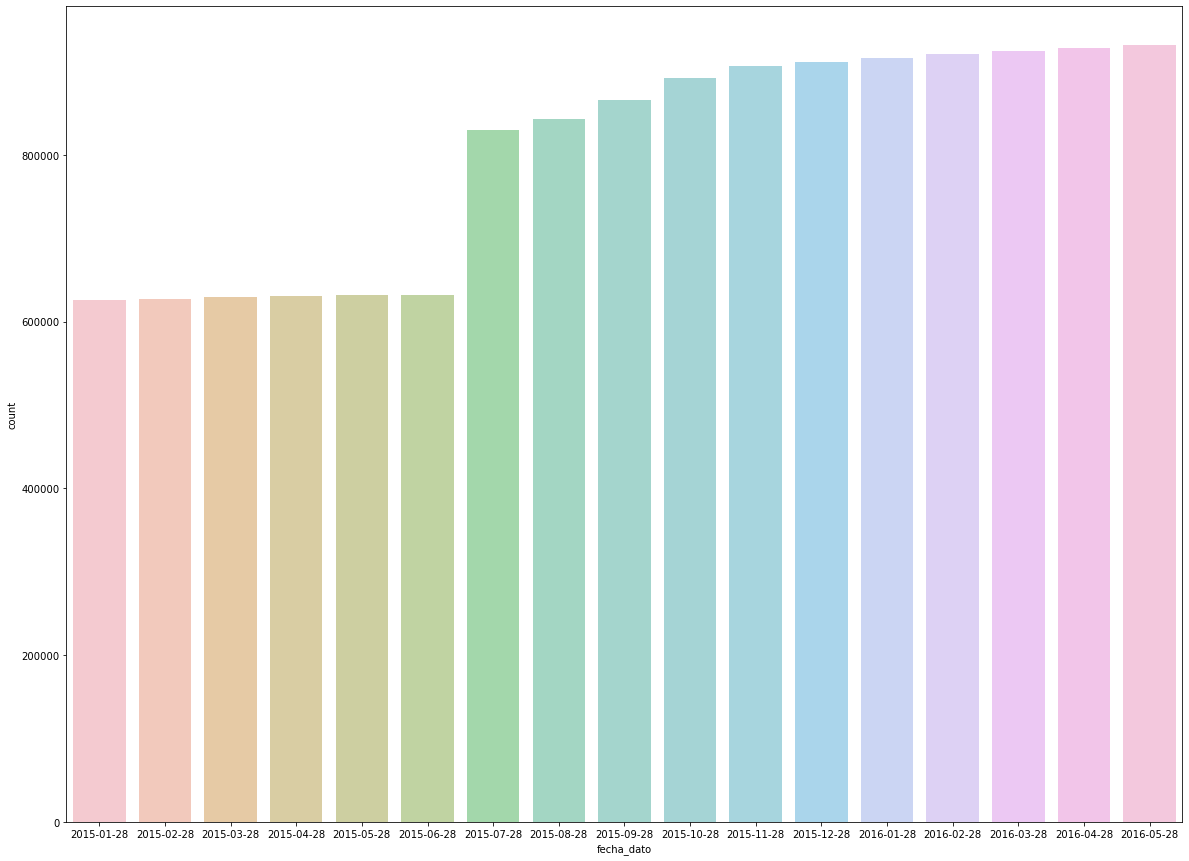

--------------------------------------------------
col:  ind_empleado


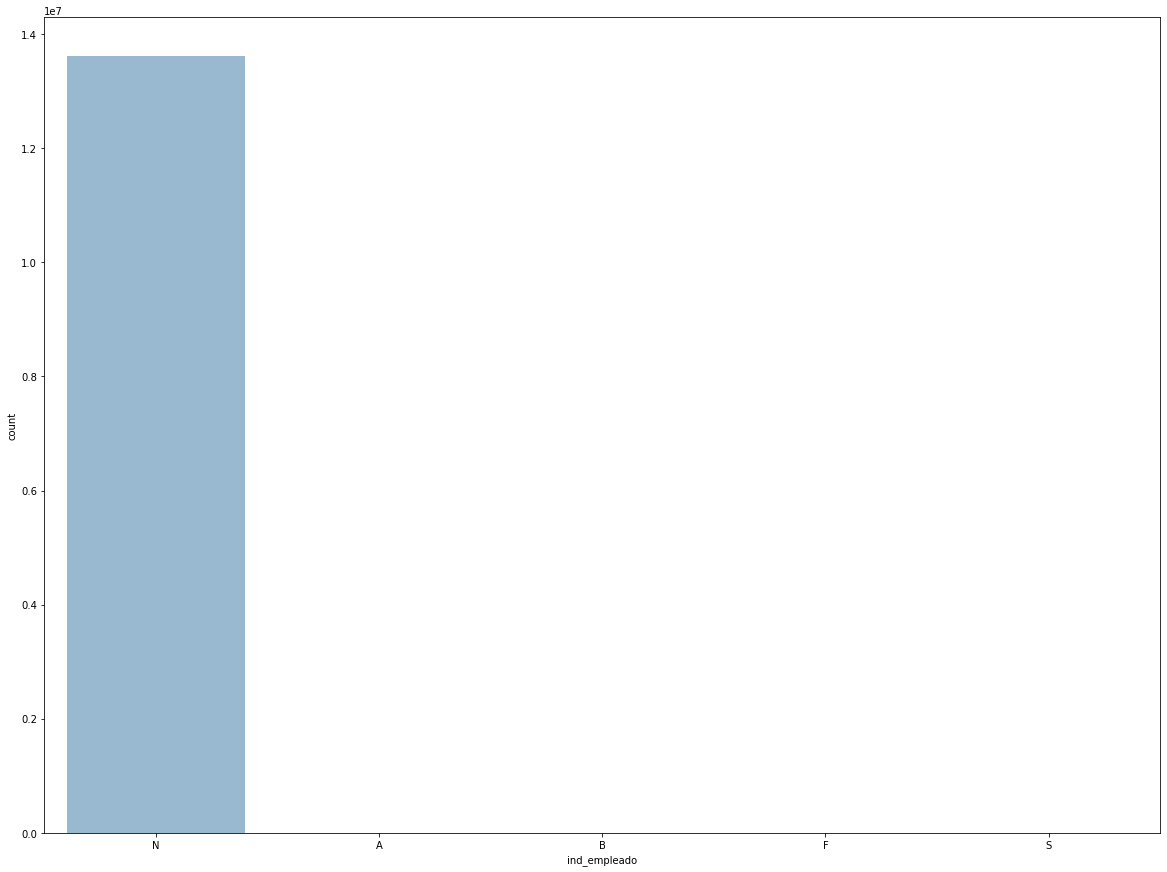

--------------------------------------------------
col:  pais_residencia


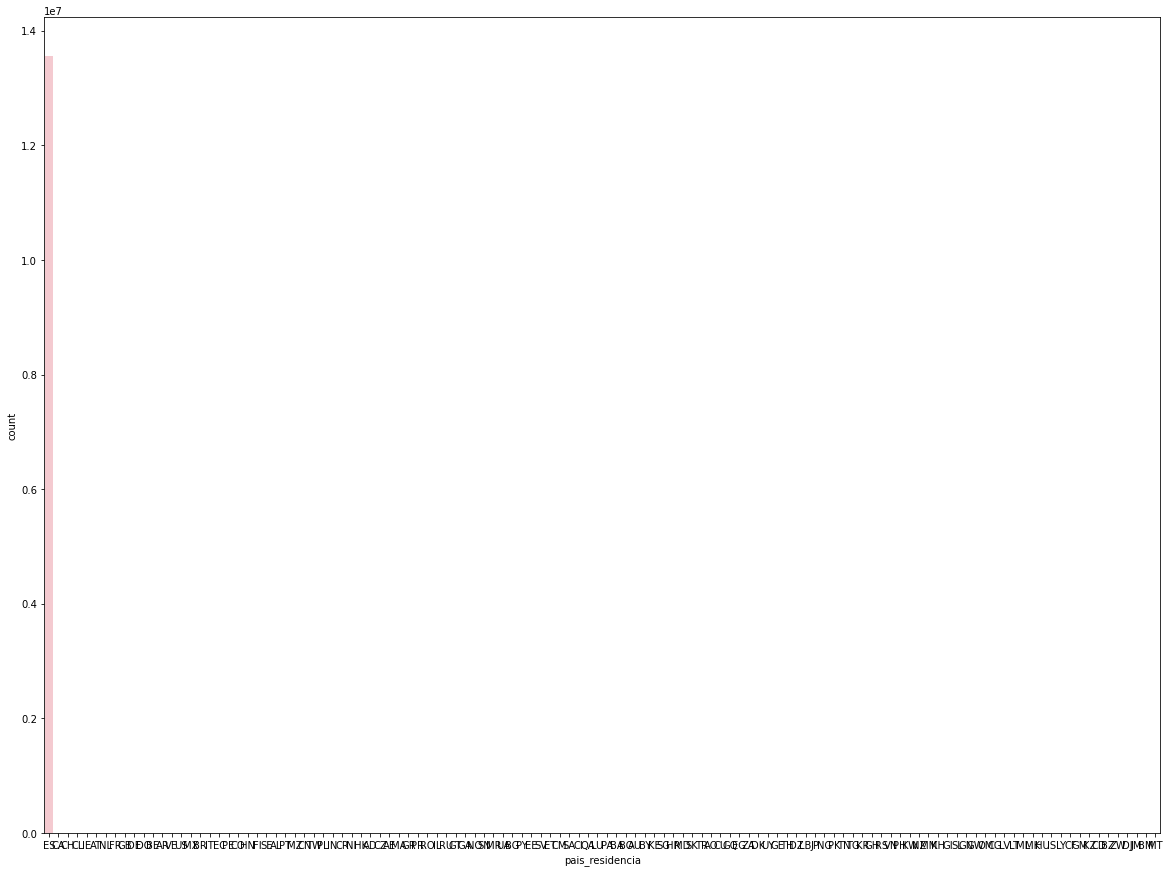

--------------------------------------------------
col:  sexo


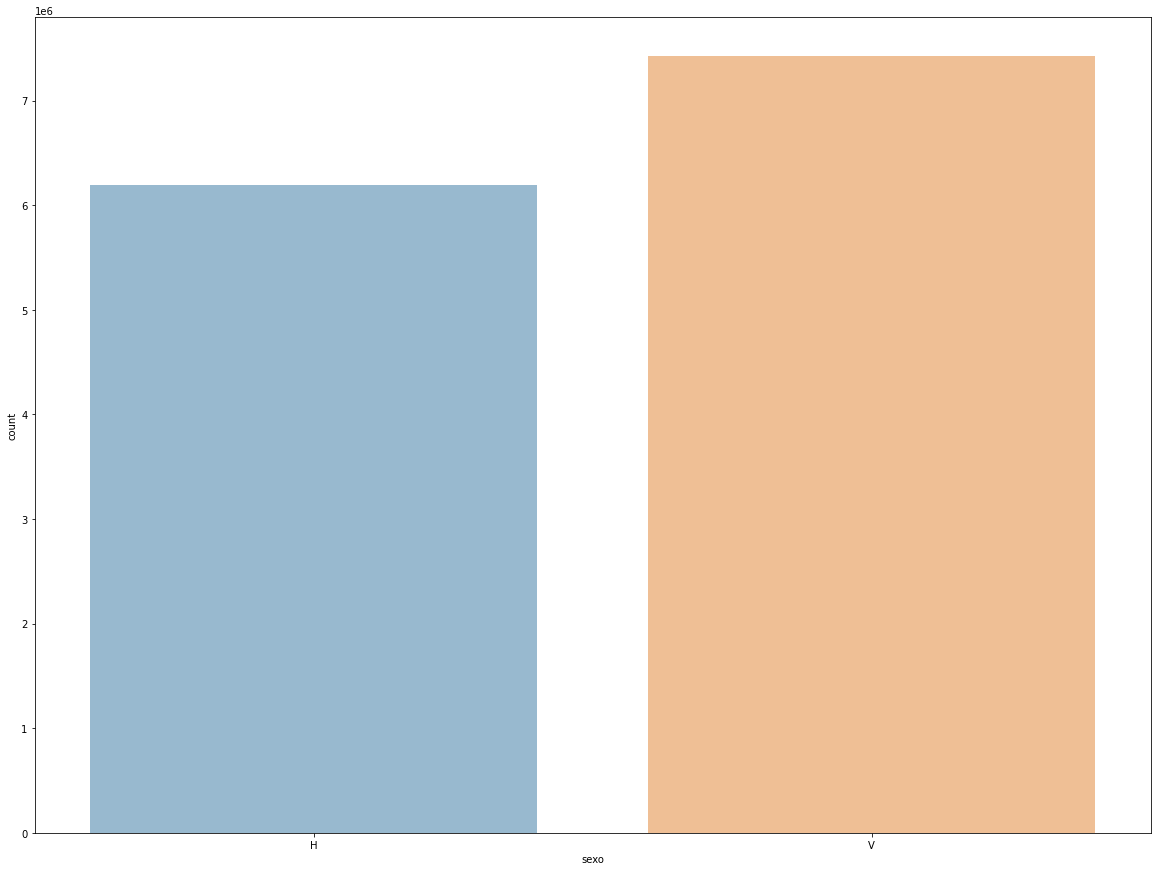

--------------------------------------------------
col:  age


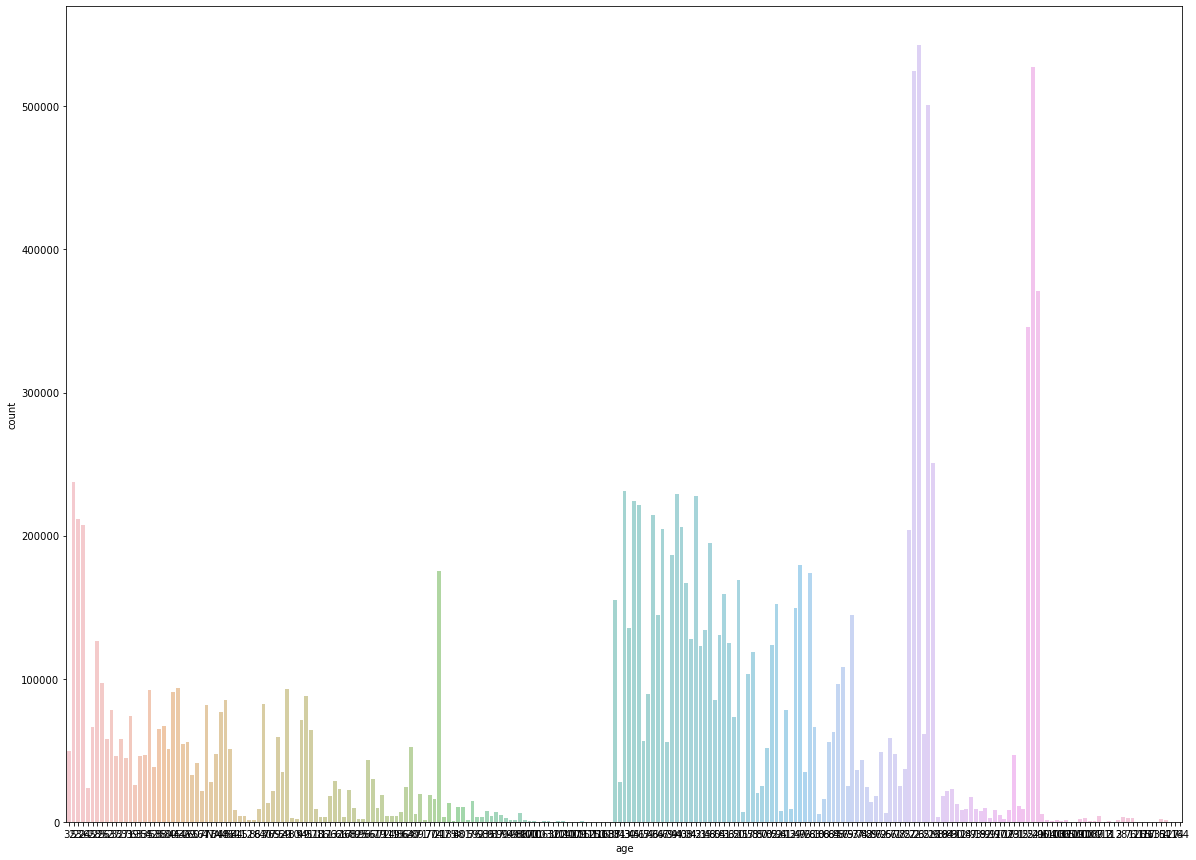

--------------------------------------------------
col:  fecha_alta


KeyboardInterrupt: 

In [16]:
# when output the variables, consider how to use it in the feature engineering
import matplotlib
import matplotlib.pyplot as plt
# graph inline in jupyter notebook
%matplotlib inline
import seaborn as sns
skip_cols = ['ncodpers', 'renta']
for col in trn.columns:
    if col in skip_cols:
        continue
    # output name
    print('-'*50)
    print('col: ', col)
    # figsize
    f, ax = plt.subplots(figsize=(20,15))
    # seaborn produce bar graph
    sns.countplot(x=col, data=trn, alpha=0.5)
    # show
    plt.show()


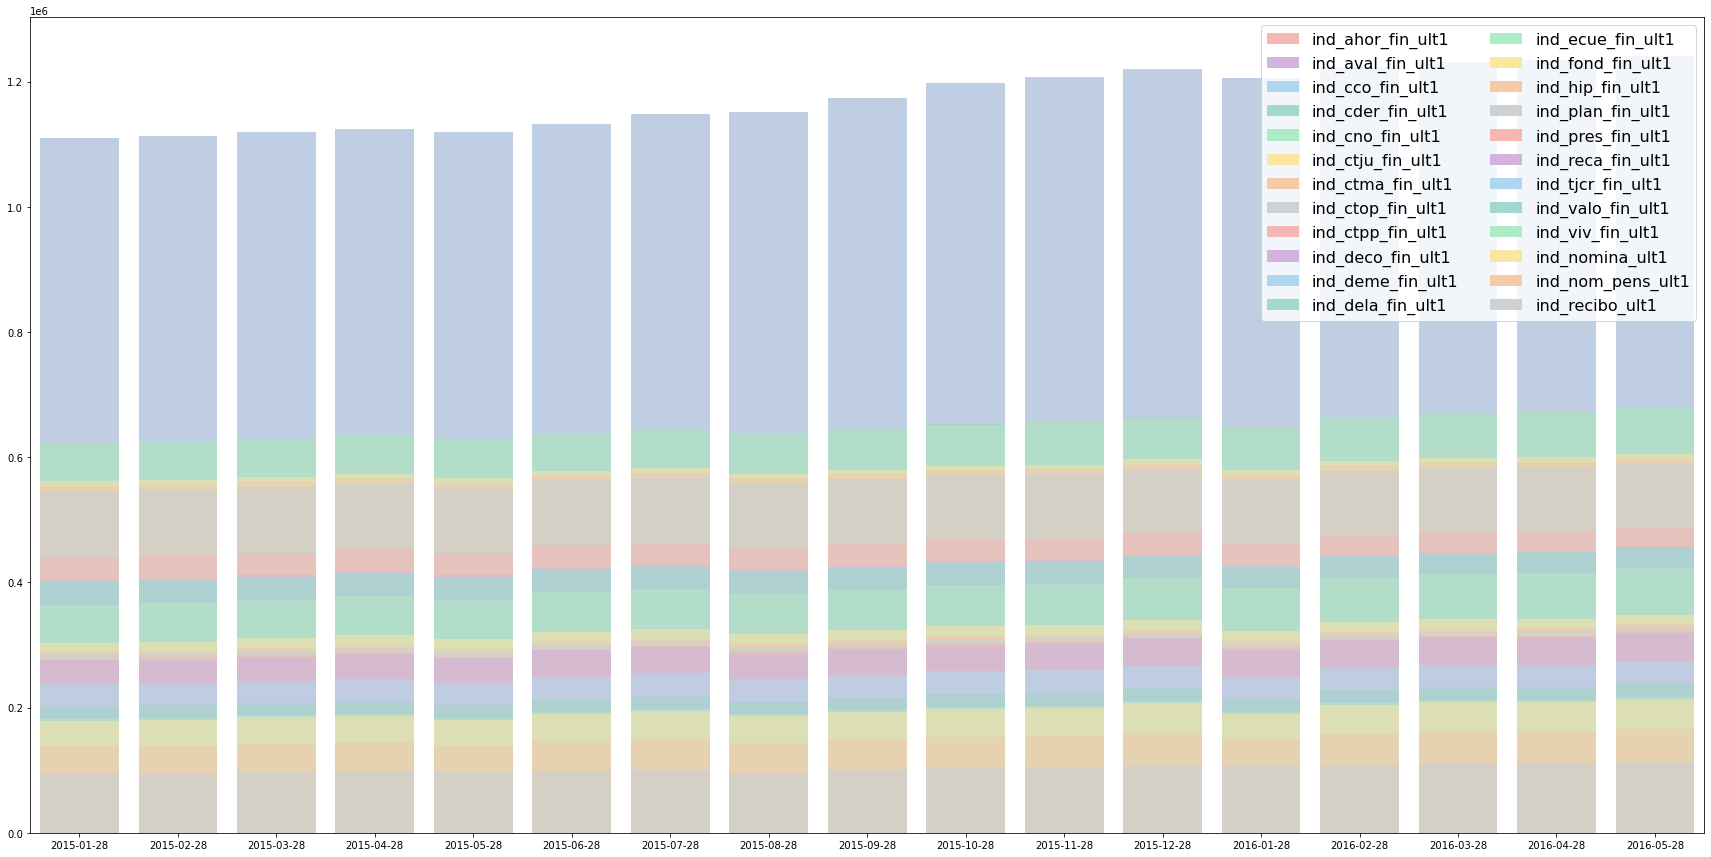

In [17]:
# time-series analysis
months = trn['fecha_dato'].unique().tolist()
# goods 24
label_cols = trn.columns[24:].tolist()

label_over_time = []
for i in range(len(label_cols)):
    label_sum = trn.groupby(['fecha_dato'])[label_cols[i]].agg('sum')
    label_over_time.append(label_sum.tolist())
label_sum_over_time = []
for i in range(len(label_cols)):
    label_sum_over_time.append(np.asarray(label_over_time[i:]).sum(axis=0))

# colors
color_list = ['#F5B7B1', '#D2B4DE', '#AED6F1', '#A2D9CE', '#ABEBC6', '#F9E79F', '#F5CBA7', '#CCD1D1']

f, ax = plt.subplots(figsize=(30,15))
for i in range(len(label_cols)):
    sns.barplot(x=months, y=label_sum_over_time[i], color=color_list[i%8], alpha=0.7)
plt.legend([plt.Rectangle((0,0), 1,1,fc=color_list[i%8], edgecolor='none')\
     for i in range(len(label_cols))], label_cols, loc=1, ncol=2, prop={'size':16})

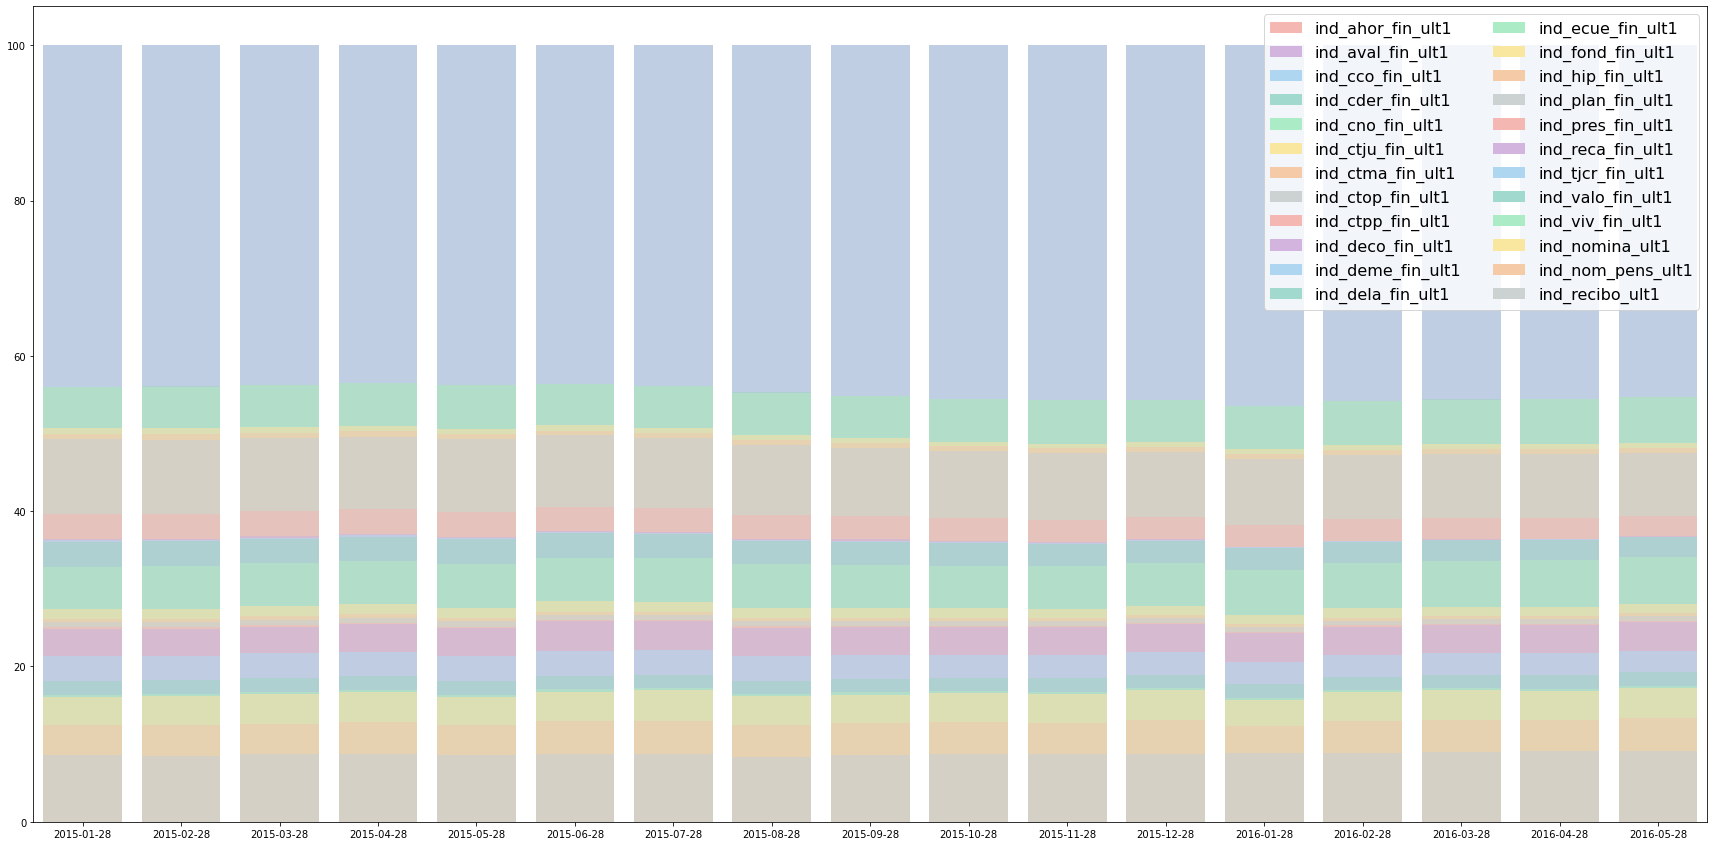

In [18]:
# try relative numbers
label_sum_percent = (label_sum_over_time / (1.*np.asarray(label_sum_over_time).max(axis=0)))*100

f,ax = plt.subplots(figsize=(30,15))
for i in range(len(label_cols)):
    sns.barplot(x=months, y=label_sum_percent[i], color=color_list[i%8], alpha=0.7)
plt.legend([plt.Rectangle((0,0), 1,1,fc=color_list[i%8], edgecolor='none')\
     for i in range(len(label_cols))], label_cols, loc=1, ncol=2, prop={'size':16})

In [30]:
# does he buy the good as a new one? labels.csv generation
prods = trn.columns[24:].tolist()
def date_to_int(str_date):
    Y, M, D = [int(a) for a in str_date.strip().split("-")]
    int_date = (int(Y) - 2015)*12 + int(M)
    return int_date
trn['int_date'] = trn['fecha_dato'].map(date_to_int).astype(np.int8) # no need to pass parameters?
trn_lag=trn.copy()
trn_lag['int_date'] +=1
trn_lag.columns = [col+'_prev' if col not in ['ncodpers', 'int_date'] else col for col in trn.columns]
df_trn = trn.merge(trn_lag, on=['ncodpers', 'int_date'], how='left')

# save mem, delete the variables
del trn, trn_lag
for prod in prods:
    prev = prod + '_prev'
    df_trn[prev].fillna(0, inplace=True)
for prod in prods:
    padd = prod + '_add'
    prev = prod + '_prev'
    df_trn[padd] = ((df_trn[prod]==1)& (df_trn[prev]==0)).astype(np.int8)
# save df - lag in labels
add_cols = [prod + '_add' for prod in prods]
labels = df_trn[add_cols].copy()
labels.columns = prods
labels.to_csv('../labels.csv', index=False)


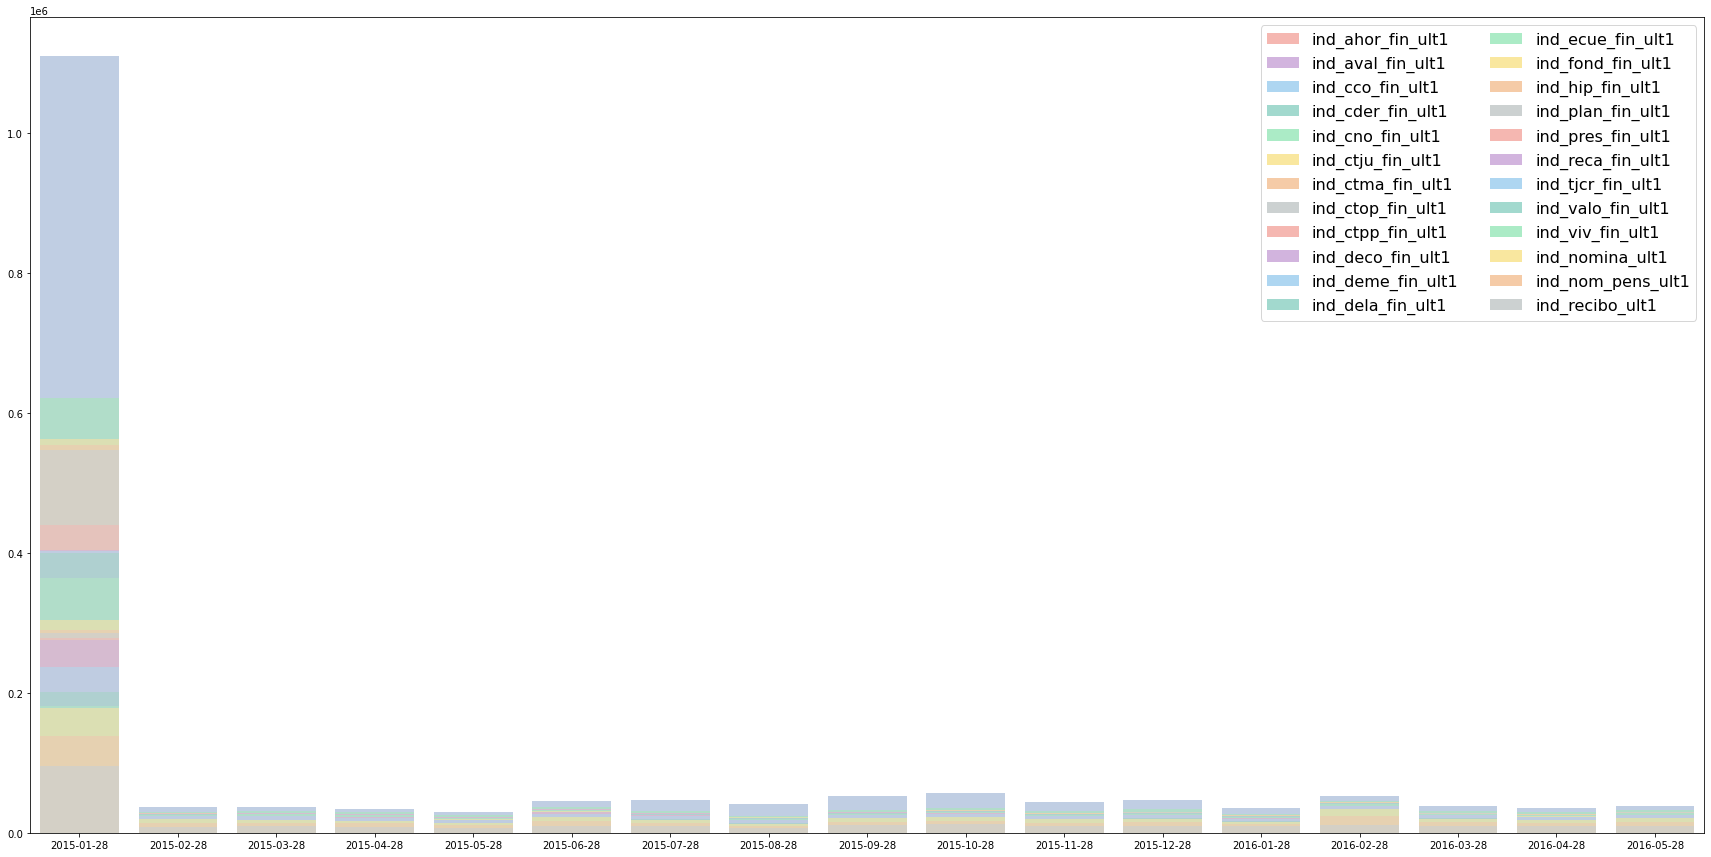

In [34]:
labels = pd.read_csv('../labels.csv').astype(int)
fecha_dato = pd.read_csv('../santander/train_ver2.csv.zip', usecols=['fecha_dato'])

labels['date'] = fecha_dato.fecha_dato
months = np.unique(fecha_dato.fecha_dato).tolist()
labels_cols = labels.columns.tolist()[:24]

label_over_time = []
for i in range(len(label_cols)):
    label_over_time.append(labels.groupby(['date'])[label_cols[i]].agg('sum').tolist())

label_sum_over_time = []
for i in range(len(label_cols)):
    label_sum_over_time.append(np.asarray(label_over_time[i:]).sum(axis=0))
    

color_list = ['#F5B7B1','#D2B4DE','#AED6F1','#A2D9CE','#ABEBC6','#F9E79F','#F5CBA7','#CCD1D1']

f,ax = plt.subplots(figsize=(30,15))
for i in range(len(label_cols)):
    sns.barplot(x=months, y=label_sum_over_time[i], color=color_list[i%8], alpha=0.7)

plt.legend([plt.Rectangle((0,0), 1,1,fc=color_list[i%8], edgecolor='none') \
    for i in range(len(label_cols))], label_cols, loc=1, ncol=2, prop={'size':16})



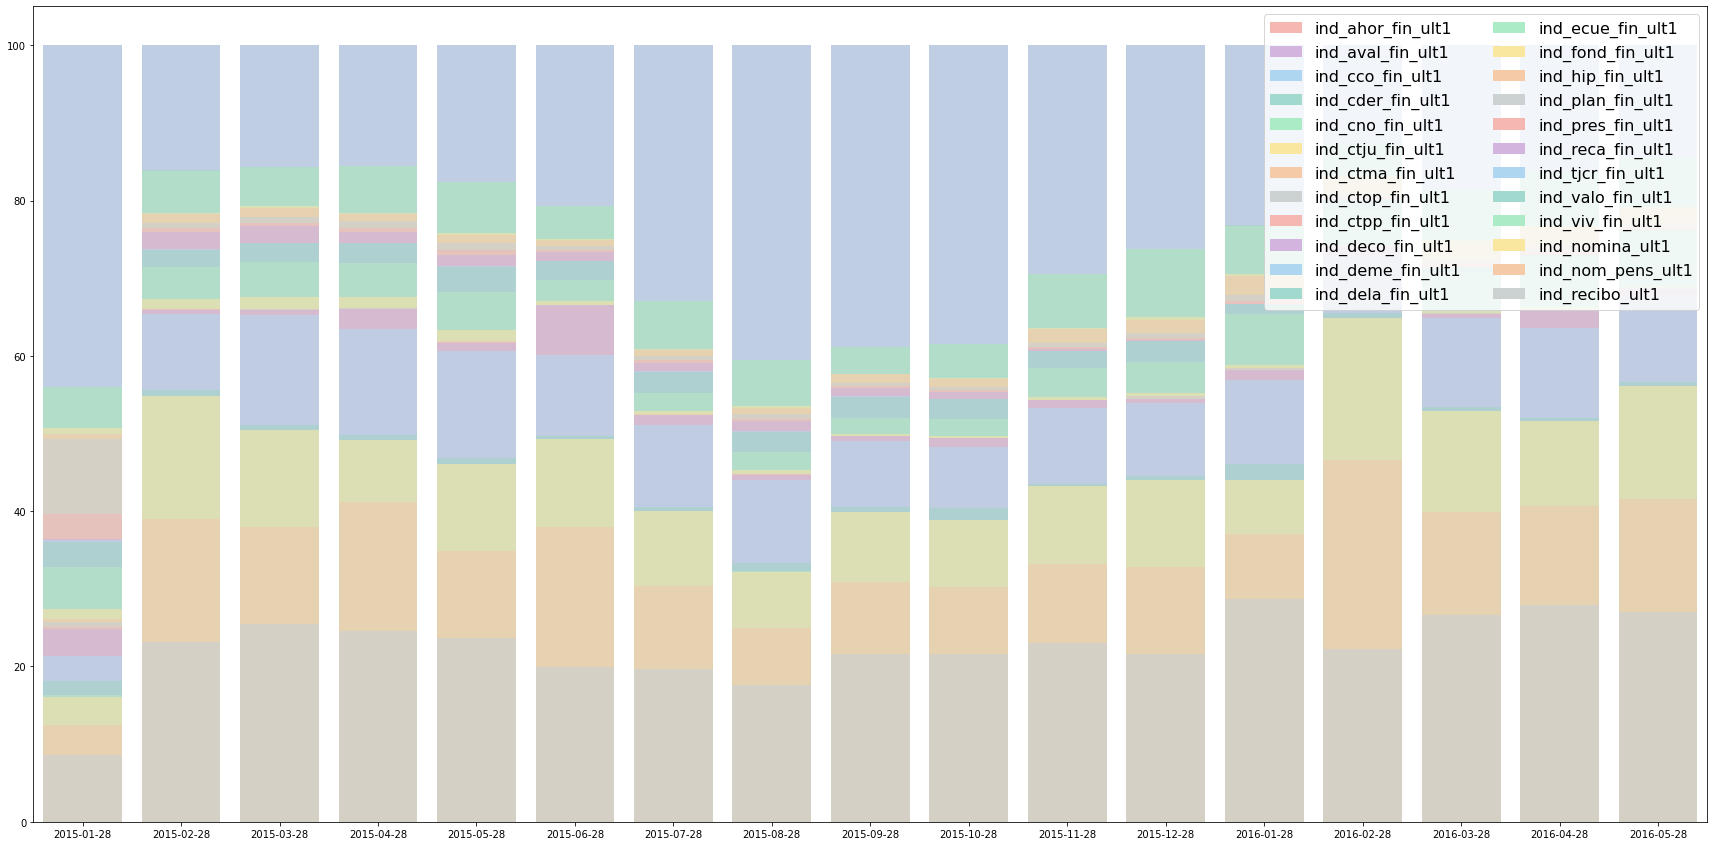

In [35]:

# try relative numbers
label_sum_percent = (label_sum_over_time / (1.*np.asarray(label_sum_over_time).max(axis=0)))*100

f,ax = plt.subplots(figsize=(30,15))
for i in range(len(label_cols)):
    sns.barplot(x=months, y=label_sum_percent[i], color=color_list[i%8], alpha=0.7)
plt.legend([plt.Rectangle((0,0), 1,1,fc=color_list[i%8], edgecolor='none')\
     for i in range(len(label_cols))], label_cols, loc=1, ncol=2, prop={'size':16})

In [36]:
## EDA:
# 1. descriptive statistics pd.
# 2. visulizations plt.


In [52]:
# 2.7 Baseline models
import pandas as pd
import numpy as np
import xgboost as xgb
np.random.seed(2018)
trn = pd.read_csv('../santander/train_ver2.csv.zip')
tst = pd.read_csv('../santander/test_ver2.csv.zip')

# preprocessing
prods = trn.columns[24:].tolist()
trn[prods] = trn[prods].fillna(0.0).astype(np.int8)

no_product = trn[prods].sum(axis=1) ==0
trn = trn[~no_product]

# merge training and test
for col in trn.columns[24:]:
    tst[col]=0
df = pd.concat([trn, tst], axis=0)

features = []
categorical_cols = ['ind_empleado', 'pais_residencia', 'sexo', 'tiprel_1mes',\
    'indresi', 'indext', 'conyuemp', 'canal_entrada', 'indfall', 'tipodom', 'nomprov', 'segmento']
for col in categorical_cols:
    df[col], _ = df[col].factorize(na_sentinel=-99)
features += categorical_cols

df['age'].replace(' NA', -99, inplace=True)
df['age'] = df['age'].astype(np.int8)

df['antiguedad'].replace('     NA', -99, inplace=True)
df['antiguedad'] = df['antiguedad'].astype(np.int8)

df['renta'].replace('         NA', -99, inplace=True)
df['renta'].fillna(-99, inplace=True)
df['renta'] = df['renta'].astype(float).astype(np.int8)

df['indrel_1mes'].replace('P', 5, inplace=True)
df['indrel_1mes'].fillna(-99, inplace=True)
df['indrel_1mes'] = df['indrel_1mes'].astype(float).astype(np.int8)

features += ['age', 'antiguedad', 'renta', 'ind_nuevo', 'indrel', 'indrel_1mes', 'ind_actividad_cliente']


/Users/shenghu/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5,8,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  self.showsyntaxerror()
/Users/shenghu/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  self.showsyntaxerror()


In [53]:
# feature engineering lag-1 variable
df['fecha_alta_month'] = df['fecha_alta'].map(lambda x: 0.0 if x.__class__ is float else float(x.split('-')[1])).astype(np.int8)
df['fecha_alta_year'] = df['fecha_alta'].map(lambda x: 0.0 if x.__class__ is float else float(x.split('-')[0])).astype(np.int16)
features += ['fecha_alta_month', 'fecha_alta_year']

df['ult_fec_cli_1t_month'] = df['ult_fec_cli_1t'].map(lambda x: 0.0 if x.__class__ is float else float(x.split('-')[1])).astype(np.int8)
df['ult_fec_cli_1t_year'] = df['ult_fec_cli_1t'].map(lambda x: 0.0 if x.__class__ is float else float(x.split('-')[0])).astype(np.int16)
features += ['ult_fec_cli_1t_month', 'ult_fec_cli_1t_year']

df.fillna(-99, inplace=True)
# lag-1
def date_to_int(str_date):
    Y, M, D = [int(a) for a in str_date.strip().split("-")]
    int_date = (int(Y) - 2015) * 12 + int(M)
    return int_date
                                                                            
# 日付を数字に変換し int_dateに保存します。
df['int_date'] = df['fecha_dato'].map(date_to_int).astype(np.int8)
                                                                            
# データをコピーし, int_date 日付に1を加え lagを生成します。変数名に _prevを追  加します。
df_lag = df.copy()
df_lag.columns = [col + '_prev' if col not in ['ncodpers', 'int_date'] else col for col in df.columns ]
df_lag['int_date'] += 1
df_trn = df.merge(df_lag, on=['ncodpers','int_date'], how='left')
                                                                            
# メモリの効率化のために、不必要な変数をメモリから除去します。
# del df, df_lag
                                                                            
# 前の月の製品情報が存在しない場合に備えて、0に代替します。
for prod in prods:
    prev = prod + '_prev'
    df_trn[prev].fillna(0, inplace=True)
df_trn.fillna(-99, inplace=True)
                                                                            
# lag-1 変数を追加します。
features += [feature + '_prev' for feature in features]
features += [prod + '_prev' for prod in prods]

# Cross validation
use_dates = ['2016-01-28', '2016-02-28','2016-03-28','2016-04-28','2016-05-28']
trn = df_trn[df_trn['fecha_dato'].isin(use_dates)]
tst = df_trn[df_trn['fecha_dato']=='2016-06-28']

X = []
Y = []
for i,prod in enumerate(prods):
    prev = prod + '_prev'
    prX = trn[(trn[prod]==1)&(trn[prev]==0)]
    prY = np.zeros(prX.shape[0], dtype=np.int8) +i
    X.append(prX)
    Y.append(prY)
XY = pd.concat(X)
Y = np.hstack(Y)
XY['y'] = Y

vld_date = '2016-05-28'
XY_trn = XY[XY['fecha_dato'] !=vld_date]
XY_vld = XY[XY['fecha_dato'] ==vld_date]

# not devote too much time into parameter tuning!!
# focus on feature engneening
# XGBoost para
param = {
    'booster': 'gbtree', 
    'max_depth': 8, 'nthread': 4, 'num_class': len(prods), 
    'objective': 'multi:softprob', 'silent': 1, 'eval_metric': 'mlogloss',
    'eta': 0.1, 'min_child_weight': 10, 'colsample_bytree': 0.8,
    'colsample_bylevel': 0.9, 'seed':2018
}


In [ ]:

X_trn = XY_trn[features].to_numpy()
Y_trn = XY_trn['y'].to_numpy()
dtrn = xgb.DMatrix(X_trn, label=Y_trn, feature_names=features)

X_vld = XY_vld[features].to_numpy()
Y_vld = XY_vld['y'].to_numpy()
dvld = xgb.DMatrix(X_vld, label=Y_vld, feature_names=features)

# learning
watch_list = [(dtrn, 'train'), (dvld, 'eval')]
model = xgb.train(param, dtrn, num_boost_round=1000, evals=watch_list, early_stopping_rounds=20)

import pickle
pickle.dump(model, open("xgb.baseline.pkl", "wb"))
best_ntree_limt = model.best_ntree_limit



In [73]:
# MAP@7
vld = trn[trn['fecha_dato'] == vld_date]
ncodpers_vld = vld['ncodpers'].to_numpy()
for prod in prods:
    prev = prod + '_prev'
    padd = prod + '_add'
    # vld[padd] = vld[prod] - vld[prev]
    vld.loc[:,padd] = vld[prod] - vld[prev]
add_vld = vld[[prod + '_add' for prod in prods]].to_numpy()
add_vld_list = [list() for i in range(len(ncodpers_vld))]

In [74]:
def apk(actual, predicted, k=7, default=0.0):
    # AP@7なので、最大7個まで使用します。
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        # 点数を付与する条件は次のとおり :
        # 予測値が正答に存在し (‘p in actual’)
        # 予測値に重複がなければ (‘p not in predicted[:i]’)
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    # 正答値が空白である場合、ともかく 0.0点を返します。
    if not actual:
        return default

    # 正答の個数(len(actual))として average precisionを求めます。
    return score / min(len(actual), k)

def mapk(actual, predicted, k=7, default=0.0):
    # list of listである正答値(actual)と予測値(predicted)から顧客別 Average Precisionを求め, np.mean()を通して平均を計算します。
    return np.mean([apk(a, p, k, default) for a, p in zip(actual, predicted)])

count_vld = 0
for ncodper in range(len(ncodpers_vld)):
    for prod in range(len(prods)):
        if add_vld[ncodper, prod]>0:
            add_vld_list[ncodper].append(prod)
            count_vld+=1
print(mapk(add_vld_list, add_vld_list, 7, 0.0))
# print(add_vld_list)

0.04266379915553903


In [75]:
# predict using vld data
X_vld = vld[features].to_numpy()
vld['y'] = 0
Y_vld = vld['y'].to_numpy()
dvld = xgb.DMatrix(X_vld, label=Y_vld, feature_names=features)
preds_vld = model.predict(dvld, ntree_limit=best_ntree_limt) # note here is a typo
# prev prod is not possible in prediction
preds_vld = preds_vld - vld[[prod + '_prev' for prod in prods]].to_numpy()

result_vld = []
for ncodper, pred in zip(ncodpers_vld, preds_vld):
    y_prods = [(y,p,ip) for y,p,ip in zip(pred, prods, range(len(prods)))]
    y_prods = sorted(y_prods, key=lambda a: a[0], reverse=True)[:7]
    result_vld.append([ip for y,p,ip in y_prods])
print(mapk(add_vld_list, result_vld, 7, 0.0))

<ipython-input-75-2ad91e551869>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vld['y'] = 0
/Users/shenghu/miniconda3/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.03647941077468356


In [77]:
# plus vld data -> retrain -> predict test data
X_all = XY[features].to_numpy()
Y_all = XY['y'].to_numpy()
dall = xgb.DMatrix(X_all, label=Y_all, feature_names=features)
watch_list = [(dall, 'train')]
# increase the # of trees as a ratio of data volume increases
best_ntree_limit = int(best_ntree_limt * (len(XY_trn) + len(XY_vld)) / len(XY_trn))
# retrain the XGBoost
model = xgb.train(param, dall, num_boost_round=best_ntree_limit, evals=watch_list)

# importance of variables
print("Feature importance: ")
for kv in sorted([(k,v) for k,v in model.get_fscore().items()], \
    key=lambda kv: kv[1], reverse=True):
    print(kv)
# submit to Kaggle
X_tst = tst[features].to_numpy()
dtst = xgb.DMatrix(X_tst, feature_names=features)
preds_tst = model.predict(dtst, ntree_limit=best_ntree_limit)
ncodpers_tst = tst['ncodpers'].to_numpy()
preds_tst = preds_tst - tst[[prod + '_prev' for prod in prods]].to_numpy()
submit_file = open('./submit.txt', 'w')
submit_file.write('ncodpers,added_products\n')
for ncodper, pred in zip(ncodpers_tst, preds_tst):
    y_prods = [(y,p,ip) for y,p,ip in zip(pred,prods,range(len(prods)))]
    y_prods = sorted(y_prods, key=lambda a:a[0], reverse=True)[:7]
    y_prods = [p for y,p,ip in y_prods]
    submit_file.write(f"{int(ncodper)},{' '.join(y_prods)}\n")


[14:28:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:2.68170
[1]	train-mlogloss:2.46856
[2]	train-mlogloss:2.29314
[3]	train-mlogloss:2.15684
[4]	train-mlogloss:2.04526
[5]	train-mlogloss:1.94643
[6]	train-mlogloss:1.86679
[7]	train-mlogloss:1.79815
[8]	train-mlogloss:1.73355
[9]	train-mlogloss:1.67876
[10]	train-mlogloss:1.62828
[11]	train-mlogloss:1.58542
[12]	train-mlogloss:1.54514
[13]	train-mlogloss:1.51041
[14]	train-mlogloss:1.47838
[15]	train-mlogloss:1.45046
[16]	train-mlogloss:1.42268
[17]	train-mlogloss:1.39846
[18]	train-mlogloss:1.37757
[19]	train-mlogloss:1.35661
[20]	train-mlogloss:1.33794
[21]	train-mlogloss:1.32075
[22]	train-mlogloss:1.30379
[23]	tra

/Users/shenghu/miniconda3/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [78]:
tst.shape

(929615, 104)

In [80]:
len(ncodpers_tst)

929615

In [82]:
submit_file = open('./submit.txt', 'w')
submit_file.write('ncodpers,added_products\n')
ccc = 0
for ncodper, pred in zip(ncodpers_tst, preds_tst):
    y_prods = [(y,p,ip) for y,p,ip in zip(pred,prods,range(len(prods)))]
    y_prods = sorted(y_prods, key=lambda a:a[0], reverse=True)[:7]
    y_prods = [p for y,p,ip in y_prods]
    ccc +=1
    submit_file.write(f"{int(ncodper)},{' '.join(y_prods)}\n")

In [83]:
print(ccc)

929615


In [84]:
# tensorflow speech recognition // pytorch, audio data

In [85]:
# safe driver prediction // tabular data, keras, anoumynous

In [ ]:
# distracted driver detection // image, keras
